$\textbf{Importing packages}$

In [2]:
#importing packages
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn import linear_model
import matplotlib.pyplot as plt
import datetime

 $\textbf{Reading Excel file saved in hard drive}$

In [3]:
#reading the file
df = pd.read_excel("share.xlsx")
df

,OBS,PRICE
0,1,975.04
1,2,977.07
2,3,966.58
3,4,964.00
4,5,956.05
...,...,...
989,990,1144.80
990,991,1170.35
991,992,1167.10
992,993,1158.31


$\textbf{Calculating daily returns and daily squared returns from SP500}$

Daily returns (R)
    $$R = 100*ln(P_t/P_{t-1})$$

In [4]:
#computing the inflation rate
df['R'] = 100*np.log(df['PRICE']/df['PRICE'].shift(1))
df = df.dropna(subset=["R"])
df

,OBS,PRICE,R
1,2,977.07,0.207980
2,3,966.58,-1.079423
3,4,964.00,-0.267277
4,5,956.05,-0.828108
5,6,927.69,-3.011259
...,...,...,...
989,990,1144.80,1.310082
990,991,1170.35,2.207290
991,992,1167.10,-0.278081
992,993,1158.31,-0.755999


In [5]:
#Selecting the first 900 observations as indicated in the question
dt = df.iloc[0:900]
dt

,OBS,PRICE,R
1,2,977.07,0.207980
2,3,966.58,-1.079423
3,4,964.00,-0.267277
4,5,956.05,-0.828108
5,6,927.69,-3.011259
...,...,...,...
896,897,1171.65,-1.640547
897,898,1190.49,1.595198
898,899,1202.93,1.039526
899,900,1205.82,0.239959


In [6]:
dta = dt.R

$\textbf{Plotting the time series: R and $R^2$}$

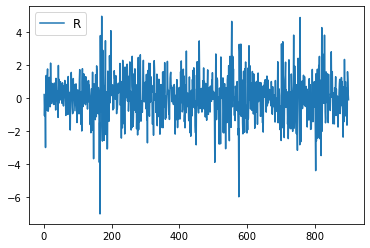

In [7]:
#plotting the R series
plt.plot(dt.R,label='R')
plt.legend(loc='best', fontsize='large')
plt.show()

$\textbf{Histogram and descriptive statistics}$

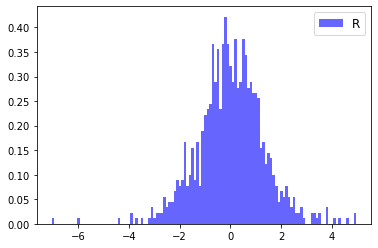

In [8]:
#Plot histogram of R
plt.hist(dta,bins=120,label='R', density=True, alpha=0.6, color='b')
plt.legend(loc='best', fontsize='large')
plt.show()

In [9]:
from scipy import stats
stats.describe(dta)

DescribeResult(nobs=900, minmax=(-7.043759037302043, 4.964596183505854), mean=0.023484214502210905, variance=1.69179462409061, skewness=-0.12386168453067394, kurtosis=2.0462044750974355)

In [10]:
stats.jarque_bera(dta)

Jarque_beraResult(statistic=159.3119858057954, pvalue=0.0)

$\textbf{EGARCH(1,1)-M}$

In [11]:
from arch import arch_model

In [12]:
#EGARCH(1,1)
model = arch_model(dta,mean ='Constant', vol ='EGARCH', p=1, o=1, q=1)
egarch =model.fit(disp='off')
#defining EGARCH's conditional volatility
dt_3 =egarch.conditional_volatility**2
#EGARCH(1,1)-M
model_1= arch_model(dta, x= dt_3, mean ='ARX', vol ='EGARCH', p=1, o=1, q=1)
egarch_m=model_1.fit(disp='off')
egarch_m

C:\Users\rluck\anaconda3\lib\site-packages\arch\univariate\mean.py:506: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  self._x = self._x[:, None]


                         AR-X - EGARCH Model Results                          
Dep. Variable:                      R   R-squared:                       0.009
Mean Model:                      AR-X   Adj. R-squared:                  0.008
Vol Model:                     EGARCH   Log-Likelihood:               -1444.42
Distribution:                  Normal   AIC:                           2900.85
Method:            Maximum Likelihood   BIC:                           2929.66
                                        No. Observations:                  900
Date:                Thu, Aug 05 2021   Df Residuals:                      898
Time:                        18:09:27   Df Model:                            2
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
Const         -0.1251  9.315e-02     -1.342      0.179  [ -0.

$\textbf{Value-at-Risk(VaR)}$

In [13]:

#Standardised residuals
std_resid =egarch_m.resid/egarch_m.conditional_volatility


In [14]:
q =  std_resid.quantile(0.01)
q

-2.42956284343608

In [15]:
#volatility
cond_vol = egarch_m.conditional_volatility
cond_var= cond_vol**2
#Mean
cond_mean= egarch_m.params['Const']+ egarch_m.params['x0']*cond_vol**2

$\textbf{VaR = (c+ $q_{0.01}\sigma_{t+1})\times$ P/100}$

In [17]:
P = 10000000
VaR = -(cond_mean+np.sqrt(cond_var)*q)*P/100
VaR.tail(1)

900    304603.986088
Name: cond_vol, dtype: float64